# 1. Importing Dependencies and Data

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import ipywidgets as widgets

2024-02-04 16:40:50.054407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
# Set up for scaling later on
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
import tensorflow_datasets as tfds
ds = tfds.load('fashion_mnist', split='train')

2024-02-04 16:40:54.400084: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 2. Visualize Data and Building Data Pipeline

In [5]:
# Some data transformation
import numpy as np

In [6]:
# Setup connection aka iterator
dataiterator = ds.as_numpy_iterator()

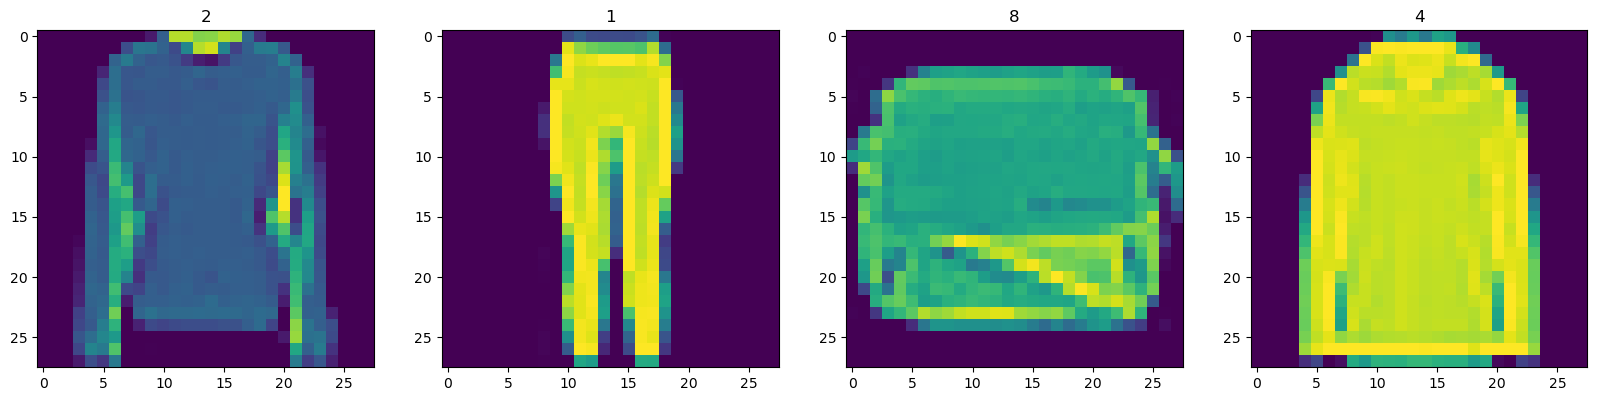

In [7]:
# Creating some subplots for 4 sample images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    batch = dataiterator.next() # Grab an image and label
    ax[idx].imshow(np.squeeze(batch['image'])) # Converting shape to 28x28 (squeeze)
    ax[idx].title.set_text(batch['label'])

In [8]:
# Scale and return images only (preprocessing)
def scale_images(data):
    image = data['image']
    return image / 255

In [9]:
# Reloading the dataset
ds = tfds.load('fashion_mnist', split='train')
ds = ds.map(scale_images) # Running the dataset through the scale_images preprocessing step
ds = ds.cache() # Cache the dataset for that batch
ds = ds.shuffle(60000) # Shuffle it up
ds = ds.batch(128) # Batch into 128 images per sample
ds = ds.prefetch(64) # Reduces the likelihood of bottlenecking

In [10]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Building Neural Network
- 3.1 Importing modelling components
- 3.2 Building the generator | Think of this as the 'artist'
- 3.3 Building the discriminator | Think of this as the 'art critic'

Importing modelling components

In [11]:
# Bring in the sequential API for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

Building the generator

In [12]:
def build_generator():
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated images
    model.add(Dense(7*7*128, input_dim=128)) # Generate based on 128 random values and shape image to 7*7*128
    model.add(LeakyReLU(0.2)) 
    model.add(Reshape((7,7,128)))
    
    # Upsampling block 1 - 14x14x128
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 - 28x28x128
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convert layer to get to one channel
    model.add(Conv2D(1,4, padding='same', activation='sigmoid')) # Sigmoid(0,1)
    
    return model

In [13]:
test_model = build_generator()

In [14]:
test_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

In [15]:
# Testing out the generator
generator = build_generator()
img = generator.predict(np.random.randn(4, 128, 1)) # Generating 4 random images using a normal distribution
img

1/1 [==============================] - 0s 166ms/step


array([[[[0.4931767 ],
         [0.48833218],
         [0.4950831 ],
         ...,
         [0.49222392],
         [0.49714053],
         [0.5000332 ]],

        [[0.4883984 ],
         [0.48119766],
         [0.49128106],
         ...,
         [0.48821932],
         [0.50434023],
         [0.49983653]],

        [[0.49269894],
         [0.47545946],
         [0.48388687],
         ...,
         [0.49117133],
         [0.5042214 ],
         [0.49747947]],

        ...,

        [[0.4924839 ],
         [0.49110225],
         [0.48713297],
         ...,
         [0.49504274],
         [0.4974397 ],
         [0.50168866]],

        [[0.49789658],
         [0.493023  ],
         [0.48828837],
         ...,
         [0.49530163],
         [0.49518076],
         [0.49917135]],

        [[0.50075173],
         [0.50054497],
         [0.49922892],
         ...,
         [0.49577472],
         [0.49711043],
         [0.4988655 ]]],


       [[[0.4981059 ],
         [0.49490544],
         [0.48

In [16]:
img.shape

(4, 28, 28, 1)

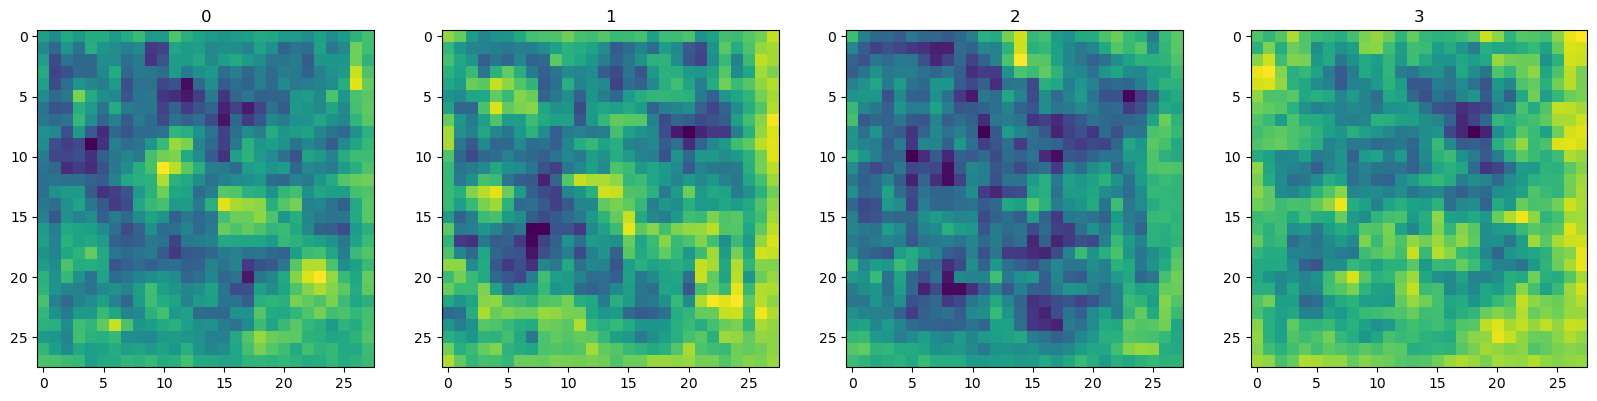

In [17]:
# Creating some subplots for 4 generated images
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop 4 times and get images
for idx, img in enumerate(img):
    # Plotting the image using a specific subplot
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as plot title
    ax[idx].title.set_text(idx)

Build Discriminator - Classifiy generated image in to 1: Fake image, 0: Real image

In [18]:
def build_discriminator():
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [19]:
discriminator = build_discriminator()

In [20]:
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 16, 16, 128)      

In [21]:
# Testing the discriminator
discriminator.predict(img) # Outputs an array of predictions from 0-1

ValueError: in user code:

    File "/Users/ammaar/opt/anaconda3/envs/GAN_Image_Generator/lib/python3.8/site-packages/keras/engine/training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "/Users/ammaar/opt/anaconda3/envs/GAN_Image_Generator/lib/python3.8/site-packages/keras/engine/training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/ammaar/opt/anaconda3/envs/GAN_Image_Generator/lib/python3.8/site-packages/keras/engine/training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "/Users/ammaar/opt/anaconda3/envs/GAN_Image_Generator/lib/python3.8/site-packages/keras/engine/training.py", line 1983, in predict_step
        return self(x, training=False)
    File "/Users/ammaar/opt/anaconda3/envs/GAN_Image_Generator/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None

    ValueError: Exception encountered when calling layer "conv2d_10" "                 f"(type Conv2D).
    
    Negative dimension size caused by subtracting 5 from 1 for '{{node sequential_2/conv2d_10/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](sequential_2/ExpandDims, sequential_2/conv2d_10/Conv2D/ReadVariableOp)' with input shapes: [?,28,1,1], [5,5,1,32].
    
    Call arguments received by layer "conv2d_10" "                 f"(type Conv2D):
      • inputs=tf.Tensor(shape=(None, 28, 1, 1), dtype=float32)


# 4. Construct Training Loop
- 4.1 Setup losses and optimizers
- 4.2 Build subclassed model
- 4.3 Build callback
- 4.4 Train
- 4.5 Review performance

Setup losses and optimizers

In [22]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both - Rewarding generator for tricking discriminator and vice versa
from tensorflow.keras.losses import BinaryCrossentropy

In [23]:
g_opt = Adam(learning_rate=0.0001) # Generator
d_opt = Adam(learning_rate=0.00001) # Discriminator

g_loss = BinaryCrossentropy() # Generator
d_loss = BinaryCrossentropy() # Discriminator

Build subclassed model - I personally have no idea how to do this from scratch, source: https://www.youtube.com/watch?v=AALBGpLbj6Q

In [24]:
# Import the base model class to subclass our training step
from tensorflow.keras.models import Model

In [25]:
class FashionGAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator 
        with tf.GradientTape() as g_tape:
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

            # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [26]:
# Create instance of subclassed model
fashgan = FashionGAN(generator, discriminator)
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

Build callback

In [27]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [28]:
class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('images', f'generated_img_{epoch}_{i}.png'))

Train, use 2000 epochs instead for optimal use, my computer is not powerful enough for even 1 epoch

In [127]:
generator.load_weights(os.path.join('archive', 'generatormodel.h5'))

ValueError: axes don't match array

In [131]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Reshape, UpSampling2D, Conv2D
from tensorflow.keras.models import load_model

# Define the generator model as provided by the user
def build_generator():
    model = Sequential([
        Dense(7*7*128, input_dim=128), # Base layer to generate from noise
        LeakyReLU(0.2),
        Reshape((7, 7, 128)), # Reshape to a format suitable for upsampling
        UpSampling2D(), # Upsample to 14x14
        Conv2D(128, 5, padding='same'),
        LeakyReLU(0.2),
        UpSampling2D(), # Upsample to 28x28
        Conv2D(128, 5, padding='same'),
        LeakyReLU(0.2),
        Conv2D(128, 4, padding='same'), # Convolutional block
        LeakyReLU(0.2),
        Conv2D(128, 4, padding='same'), # Another convolutional block
        LeakyReLU(0.2),
        Conv2D(1, 4, padding='same', activation='sigmoid') # Final layer to generate image
    ])
    return model

# Instantiate the generator model
generator = build_generator()

# Try to load the weights into the generator
weights_path = '/Users/ammaar/DataspellProjects/GAN_Image_Generator/archive/generatormodel.h5'

try:
    generator.load_weights(weights_path)
    result = "Weights loaded successfully."
except Exception as e:
    result = f"Error loading weights: {str(e)}"

result


"Error loading weights: axes don't match array"

In [124]:
imgs = generator.predict(tf.random.normal((16, 128, 1)))

1/1 [==============================] - 1s 654ms/step


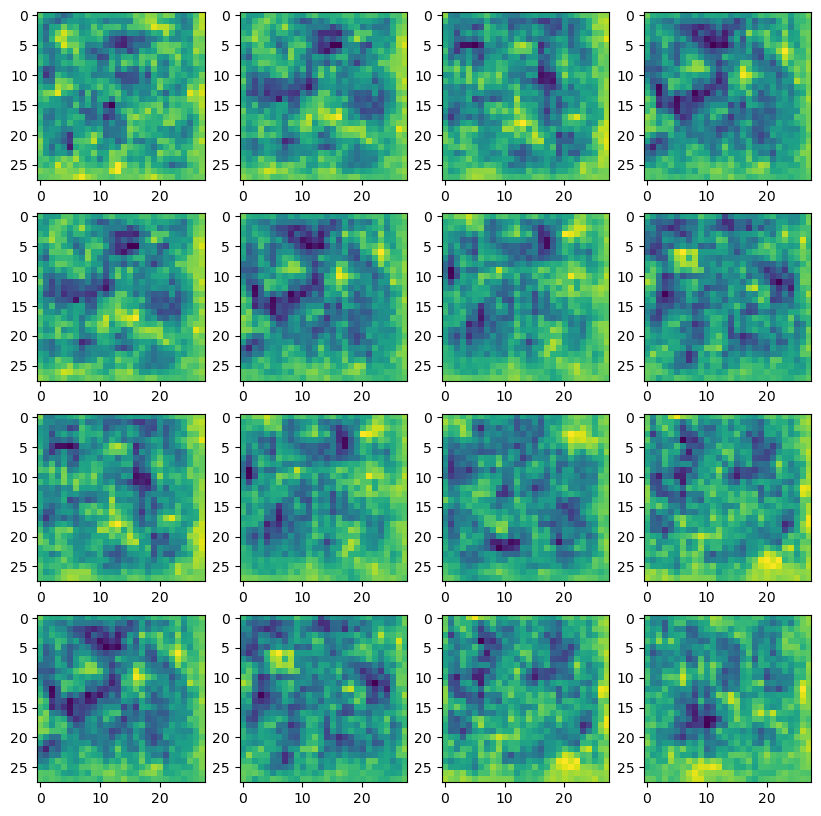

In [125]:


fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4):
    for c in range(4):
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

